In [1]:
import torch
import sys
sys.path.append('../vega/')
import vega
import scanpy as sc
import scvi
from scipy import sparse
from sklearn import preprocessing
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
path_to_save = '../paper/figures/correlation_z/'
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)
font = {'family' : 'Arial',
        'size'   : 14}
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['axes.linewidth'] = .5
matplotlib.rcParams['lines.linewidth'] = .5
matplotlib.rcParams['patch.linewidth'] = .5
matplotlib.rc('font', **font)
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
# Scanpy figures params
sc.set_figure_params(dpi_save=300)
sc.settings.figdir = path_to_save

In [2]:
# Reload model and data
model_0 = vega.VEGA.load('../trained_models/corr_z/vega_zdrop0/')
model_05 = vega.VEGA.load('../trained_models/corr_z/vega_zdrop05/')

Using masked decoder
Constraining decoder to positive weights
Model successfully loaded.
Using masked decoder
Constraining decoder to positive weights
Model successfully loaded.


In [3]:
import pandas as pd
df_0 = pd.DataFrame(data=model_0.to_latent(model_0.adata, return_mean=True),
                    columns=model_0.adata.uns['_vega']['gmv_names'],
                    index=np.arange(len(model_0.adata)))
df_05 = pd.DataFrame(data=model_05.to_latent(model_05.adata, return_mean=True),
                    columns=model_05.adata.uns['_vega']['gmv_names'],
                    index=np.arange(len(model_05.adata)))

## Plot

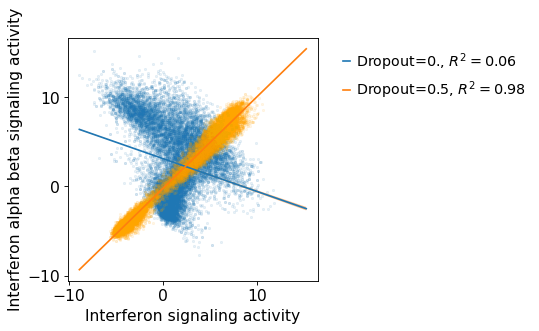

In [58]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns
x = 'REACTOME_INTERFERON_SIGNALING'
y = 'REACTOME_INTERFERON_ALPHA_BETA_SIGNALING'
l = np.linspace(np.min(df_0[x]), np.max(df_0[y]), 1000)
plt.scatter(df_0[x],
           df_0[y],
           s=5,
           alpha=0.1)
res = linregress(df_0[x], df_0[y])
m, b, corr, p, m_std= res
b_std = res.intercept_stderr
plt.plot(l, m*l+b, label='Dropout=0., $R^2=%.2f$'%corr**2)
plt.fill_between(l, (m-m_std)*l + (b-b_std), ((m+m_std)*l + (b+b_std)), alpha=0.5)
plt.scatter(df_05[x],
           df_05[y],
           s=5,
           alpha=0.1, c='orange', rasterized=True)
res = linregress(df_05[x], df_05[y])
m, b, corr, p, m_std= res
b_std = res.intercept_stderr
plt.plot(l, m*l+b, label=r'Dropout=0.5, $R^2=%.2f$'%corr**2)
plt.fill_between(l, (m-m_std)*l + (b-b_std), ((m+m_std)*l + (b+b_std)), alpha=0.5)
plt.xlabel('Interferon signaling activity')
plt.ylabel('Interferon alpha beta signaling activity')
plt.xticks([-10,0,10])
plt.yticks([-10,0,10])
plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.grid(False)
plt.savefig(path_to_save+'interferons_corr.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


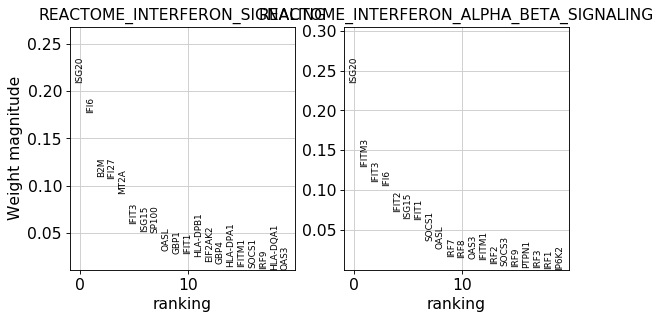

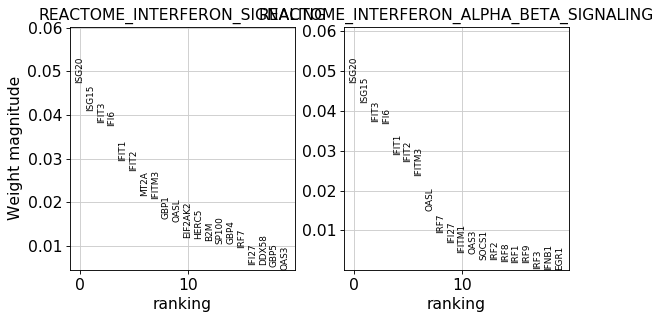

In [6]:
vega.plotting.rank_gene_weights(model_0,
                                gmv_list=['REACTOME_INTERFERON_SIGNALING',
                                          'REACTOME_INTERFERON_ALPHA_BETA_SIGNALING'], n_genes=20,
                                color_in_set=False)

vega.plotting.rank_gene_weights(model_05,
                                gmv_list=['REACTOME_INTERFERON_SIGNALING',
                                          'REACTOME_INTERFERON_ALPHA_BETA_SIGNALING'], n_genes=20,
                                color_in_set=False)

In [7]:
model_0.adata.uns['_vega']['gmv_names'] = np.array([vega.plotting._make_pretty(k) for k in model_0.adata.uns['_vega']['gmv_names']])
model_05.adata.uns['_vega']['gmv_names'] = np.array([vega.plotting._make_pretty(k) for k in model_05.adata.uns['_vega']['gmv_names']])

Saving figure at ../figures/correlation_z/hm_dropout0.pdf


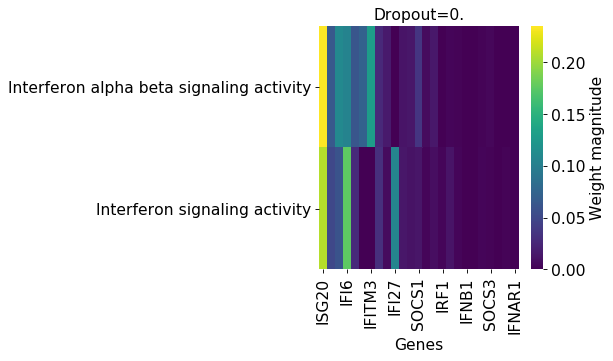

Model dropout=0.5
Saving figure at ../figures/correlation_z/hm_dropout05.pdf


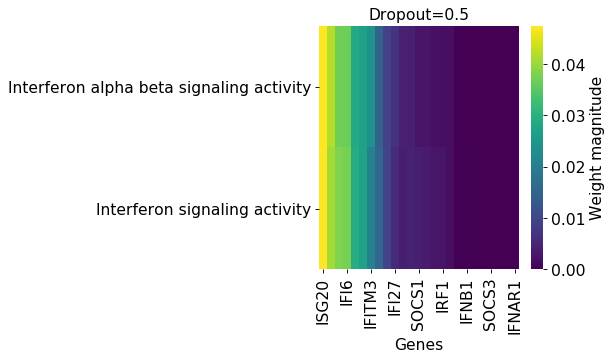

In [53]:
pathway_dict = vega.utils._read_gmt('../data/reactomes.gmt')
gene_subset = list(set(pathway_dict['REACTOME_INTERFERON_ALPHA_BETA_SIGNALING']).intersection(set(pathway_dict['REACTOME_INTERFERON_SIGNALING'])))
gene_subset = list(set(model_05.adata.var_names).intersection(set(gene_subset)))
weights_05 = np.array(model_05.decoder._get_weights().data).T
vec = weights_05[list(model_05.adata.uns['_vega']['gmv_names']).index('Interferon alpha beta signaling activity'),:]
vec = vec[np.isin(model_05.adata.var_names, gene_subset)]
gene_subset = np.array(model_05.adata.var_names)[np.isin(model_05.adata.var_names, gene_subset)]
sort_genes = np.argsort(vec)[::-1]
gene_subset = list(np.array(gene_subset)[sort_genes])

vega.plotting.weight_heatmap(model_0,
               cluster=False,
               title='Dropout=0.',
               display_gmvs=['Interferon alpha beta signaling activity',
                            'Interferon signaling activity'],
               display_genes=gene_subset,
               save=path_to_save+'hm_dropout0.pdf')
print('Model dropout=0.5')
vega.plotting.weight_heatmap(model_05,
               cluster=False,
               title='Dropout=0.5',
               display_gmvs=['Interferon alpha beta signaling activity',
                            'Interferon signaling activity'],
               display_genes=gene_subset,
               save=path_to_save+'hm_dropout05.pdf')

In [18]:
# Correlation
weights_0 = np.array(model_0.decoder._get_weights().data).T
weights_05 = np.array(model_05.decoder._get_weights().data).T
vec_0 = weights_0[np.isin(model_0.adata.uns['_vega']['gmv_names'], ['Interferon signaling activity', 'Interferon alpha beta signaling activity'])][:,
                     np.isin(model_0.adata.var_names, gene_subset)]
print('$^2 dropout=0.:', np.corrcoef(vec_0[0], vec_0[1])[0,1])
vec_05 = weights_05[np.isin(model_05.adata.uns['_vega']['gmv_names'], ['Interferon signaling activity', 'Interferon alpha beta signaling activity'])][:,
                     np.isin(model_05.adata.var_names, gene_subset)]
print('R^2 dropout=0.5:', np.corrcoef(vec_05[0], vec_05[1])[0,1])

$^2 dropout=0.: 0.7151084178963781
R^2 dropout=0.5: 0.9984079299492904
